In [1]:
from google.colab import drive
drive.mount('/content/drive',  force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install transformers

     |████████████████████████████████| 778kB 7.2MB/s 
     |████████████████████████████████| 3.0MB 40.8MB/s 
     |████████████████████████████████| 1.1MB 41.8MB/s 
     |████████████████████████████████| 890kB 41.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=6b28d55b8d83168fa05101a3871e8cc7b5eb5ad3e4f14bd997c0ab31ba3ec62a
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [3]:
import transformers
import numpy as np
import json
import pandas as pd
import re
import io

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K
import sklearn.metrics as metrics

In [6]:
nlp = transformers.TFBertModel.from_pretrained('distilbert-base-uncased')

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing TFBertModel: ['vocab_transform', 'distilbert', 'activation_13', 'vocab_projector', 'vocab_layer_norm']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of TFBertModel were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['bert']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
tokenizer = transformers.AutoTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)

In [8]:
def load_files(i):

    df_X_train= pd.read_pickle('/content/drive/My Drive/Python Notebook/SCS_CONVEX/data-files/X_train_' + str(i) + '.pkl')
    df_X_test= pd.read_pickle('/content/drive/My Drive/Python Notebook/SCS_CONVEX/data-files/X_test_' + str(i) + '.pkl')
    df_Y_train=pd.read_pickle('/content/drive/My Drive/Python Notebook/SCS_CONVEX/data-files/Y_train_' + str(i) + '.pkl')
    df_Y_test=pd.read_pickle('/content/drive/My Drive/Python Notebook/SCS_CONVEX/data-files/Y_test_' + str(i) + '.pkl')
    df_train = pd.concat([df_X_train,df_Y_train], axis=1)
    df_test = pd.concat([df_X_test,df_Y_test], axis=1)

    #print(list(df_train.columns))

    df_train = df_train[["Speech_acts","Content"]]
    df_train = df_train.rename(columns={"Speech_acts":"y", "Content":"text"})

    

    df_test = df_test[["Speech_acts","Content"]]
    df_test = df_test.rename(columns={"Speech_acts":"y", "Content":"text"})

    return df_train,df_test,df_Y_train,df_Y_test

In [9]:
def generate_maskid(training, test):
  #print(training['text'])
  corpus_train = training['text']
  corpus_test = test['text']
  #the length of the feature vector is 150
  maxlen = 150

  #add special tokens
  maxqnans = np.int((maxlen-20)/2)
  corpus_tokenized_train = ["[CLS] "+
              " ".join(tokenizer.tokenize(re.sub(r'[^\w\s]+|\n', '', 
              str(txt).lower().strip()))[:maxqnans])+
              " [SEP] " for txt in corpus_train]
  corpus_tokenized_test = ["[CLS] "+
              " ".join(tokenizer.tokenize(re.sub(r'[^\w\s]+|\n', '', 
              str(txt).lower().strip()))[:maxqnans])+
              " [SEP] " for txt in corpus_test]
  #generate masks
  masks_train = [[1]*len(txt.split(" ")) + [0]*(maxlen - len(txt.split(" "))) for txt in corpus_tokenized_train]
  masks_test = [[1]*len(txt.split(" ")) + [0]*(maxlen - len(txt.split(" "))) for txt in corpus_tokenized_test]

  #padding
  txt2seq_train = [txt + " [PAD]"*(maxlen-len(txt.split(" "))-2) if len(txt.split(" ")) != (maxlen) else txt for txt in corpus_tokenized_train]
  txt2seq_test = [txt + " [PAD]"*(maxlen-len(txt.split(" "))-2) if len(txt.split(" ")) != (maxlen) else txt for txt in corpus_tokenized_test]

  #generate idx
  idx_train = [tokenizer.encode(seq.split(" ")) for seq in txt2seq_train]
  idx_test = [tokenizer.encode(seq.split(" ")) for seq in txt2seq_test]      

  ## feature matrix
  X_train = [np.asarray(idx_train, dtype='int32'), 
            np.asarray(masks_train, dtype='int32')]
  X_test = [np.asarray(idx_test, dtype='int32'), 
            np.asarray(masks_test, dtype='int32')]
  i = 0
  #print("txt: ", training["text"].iloc[0])
  #print("tokenized:", [tokenizer.convert_ids_to_tokens(idx) for idx in X_train[0][i].tolist()])
  #print("idx: ", X_train[0][i])
  #print("mask: ", X_train[1][i])
  return X_train, X_test


In [10]:
def model_generate(y_train):

  ## inputs
  idx = layers.Input((150), dtype="int32", name="input_idx")
  masks = layers.Input((150), dtype="int32", name="input_masks")
  ## pre-trained bert with config
  config = transformers.DistilBertConfig(dropout=0.2,attention_dropout=0.2)
  config.output_hidden_states = False
  nlp = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased', config=config)
  bert_out = nlp(idx, attention_mask=masks)[0]
  ## fine-tuning
  x = layers.GlobalAveragePooling1D()(bert_out)
  x = layers.Dense(64, activation="relu")(x)
  #x = layers.Dense(32, activation="relu")(x)
  y_out = layers.Dense(len(np.unique(y_train)), activation='softmax')(x)

  #nlp2 = transformers.TFDistilBertModel.from_pretrained('distilroberta-base', config=config)
  #bert_out2 = nlp2(idx, attention_mask=masks)[0]
  #x2 = layers.GlobalAveragePooling1D()(bert_out2)
  #x2 = layers.Dense(32, activation="relu")(x2)
  #y_out = layers.Dense(len(np.unique(y_train)), activation='softmax')(x2)



  ## compile
  model = models.Model([idx, masks], y_out)
  for layer in model.layers[:3]:
      layer.trainable = False
  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.summary()

  return model

In [11]:
def model_train(X_train, y_train, model):

  ## encode y
  dic_y_mapping = {n:label for n,label in enumerate(np.unique(y_train))}
  print(dic_y_mapping)
  inverse_dic = {v:k for k,v in dic_y_mapping.items()}
  print(inverse_dic)
  y_train2 = np.array([inverse_dic[y] for y in y_train])
  ## train
  training = model.fit(x=X_train, y=y_train2, batch_size=32, epochs=300, shuffle=True, verbose=1, validation_split=0.3)

  training_acc = training.history['accuracy']
  training_loss = training.history['loss']
  #print(acc)
  #loss, accuracy = model.evaluate(x=X_test, y=y_test, batch_size=32, verbose=1)
  return training_acc, training_loss
  #loss, accuracy = model.evaluate(x=X_train, y=y_train, batch_size=32, verbose=1)

In [12]:
def test_classification(X_test, y_test, y_train):

  dic_y_mapping = {n:label for n,label in enumerate(np.unique(y_train))}
  #print(np.unique(y_test))
  predicted_prob = model.predict(X_test)
  #print(predicted_prob)
  predicted = [dic_y_mapping[np.argmax(pred)] for pred in predicted_prob]

  return predicted, predicted_prob

In [13]:
def result_visualization(y_test, predicted, predicted_prob,y_train):

  classes = np.unique(y_test)
  y_test_array = pd.get_dummies(y_test, drop_first=False).values
      
  ## Accuracy, Precision, Recall
  accuracy = metrics.accuracy_score(y_test, predicted)
  #auc = metrics.roc_auc_score(y_train, predicted_prob, 
  #                            multi_class="ovr")
  details = metrics.classification_report(y_test, predicted)
  print("Accuracy:",  accuracy)
  #print("Auc:", round(auc,2))
  print("Detail:")
  print(metrics.classification_report(y_test, predicted))
      
  ## Plot confusion matrix
  cm = metrics.confusion_matrix(y_test, predicted)
  fig, ax = plt.subplots()
  sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
              cbar=False)
  ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
        yticklabels=classes, title="Confusion matrix")
  plt.yticks(rotation=0)

  #fig, ax = plt.subplots(nrows=1, ncols=2)
  ## Plot roc
  #for i in range(len(classes)):
   #   fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
   #                         predicted_prob[:,i])
   #   ax[0].plot(fpr, tpr, lw=3, 
   #             label='{0} (area={1:0.2f})'.format(classes[i], 
   #                             metrics.auc(fpr, tpr))
   #            )
  #ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
  #ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
   #         xlabel='False Positive Rate', 
   #         ylabel="True Positive Rate (Recall)", 
   #         title="Receiver operating characteristic")
  #ax[0].legend(loc="lower right")
  #ax[0].grid(True)
      
  ## Plot precision-recall curve
  #for i in range(len(classes)):
  #    precision, recall, thresholds = metrics.precision_recall_curve(
  #                y_test_array[:,i], predicted_prob[:,i])
  #             label='{0} (area={1:0.2f})'.format(classes[i], 
  #                                  metrics.auc(recall, precision))
  #             )
  #ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
  #          ylabel="Precision", title="Precision-Recall curve")
  #ax[1].legend(loc="best")
  #ax[1].grid(True)
  plt.show()

  return accuracy, details, cm

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'activation_13', 'vocab_projector', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_idx (InputLayer)          [(None, 150)]        0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 150)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model (TFDistilB ((None, 150, 768),)  66362880    input_idx[0][0]                  
                                                                 input_masks[0][0]                
__________________________________________________________________________________________________
global_average_pooling1d (Globa (None, 768)          0           tf_distil_bert_model[0

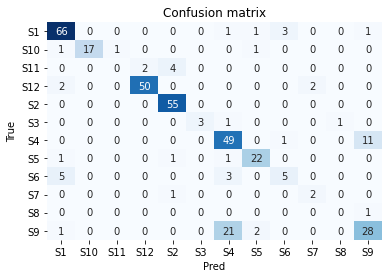

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'activation_13', 'vocab_projector', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_idx (InputLayer)          [(None, 150)]        0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 150)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model_1 (TFDisti ((None, 150, 768),)  66362880    input_idx[0][0]                  
                                                                 input_masks[0][0]                
__________________________________________________________________________________________________
global_average_pooling1d_1 (Glo (None, 768)          0           tf_distil_bert_model_1

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.8065395095367848
Detail:
              precision    recall  f1-score   support

          S1       0.84      0.93      0.88        68
         S10       0.96      0.90      0.93        29
         S11       0.50      0.17      0.25         6
         S12       0.95      0.96      0.95        55
          S2       0.89      1.00      0.94        58
          S3       1.00      0.50      0.67         4
          S4       0.78      0.66      0.71        76
          S5       0.80      0.83      0.82        24
          S6       1.00      0.50      0.67        10
          S7       0.33      0.50      0.40         2
          S8       0.00      0.00      0.00         1
          S9       0.40      0.50      0.44        34

    accuracy                           0.81       367
   macro avg       0.70      0.62      0.64       367
weighted avg       0.81      0.81      0.80       367



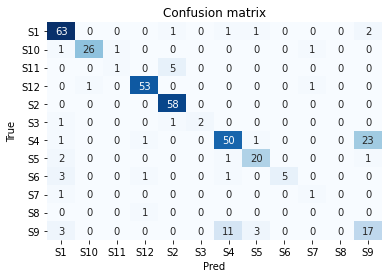

In [14]:

file = open('/content/drive/My Drive/Python Notebook/SCS_CONVEX/output/BERT/bert_op.txt','w')
file.close()


if __name__ == '__main__':
  
  df_prediction = pd.DataFrame()
  df_accuracy =  pd.DataFrame()
  file = open('/content/drive/My Drive/Python Notebook/SCS_CONVEX/output/BERT/bert_op.txt','w')
  
  for i in range(14,16):

    df_train,df_test,df_Y_train,df_Y_test = load_files(i)
    y_train = df_Y_train['Speech_acts'].to_list()
    y_test = df_Y_test['Speech_acts'].to_list()
    X_train, X_test = generate_maskid(df_train,df_test)
    model = model_generate(y_train)
    training_acc, training_loss = model_train(X_train,y_train, model)
    predicted, predicted_prob = test_classification(X_test,y_test,y_train)
    #loss, categorical_accuracy = trained_model.evaluate(x=X_test, y=y_test, batch_size=32, verbose=1)
    test_acc, details, conf_mat = result_visualization(y_test, predicted, predicted_prob,y_train)
    

    outputname = 'bert_'+ str(i)
    df_prediction[outputname] = predicted
    df_accuracy[i] = [test_acc]
    file.write("\nIteration:" + str(i) + "\nCategorical Accuracy:" + str(test_acc) + 
                    "\nConfusion Matrix:\n" + str(conf_mat) + "\n\n")


  df_prediction.to_csv('/content/drive/My Drive/Python Notebook/SCS_CONVEX/output/BERT/bert_predictions.csv')    
  df_accuracy.to_csv('/content/drive/My Drive/Python Notebook/SCS_CONVEX/output/BERT/bert_accuracy.csv')    
  file.close()

